### In thi notebook we shall look at some of the trrained models on different types of data to see whether there is some kind of structure int he latent space. UMAP will be needed in those cases where the dimensionality of the latent space is > 2. Use only TSVAE pretrained models as the should contain about the same information as AE and definitely the same as VAE.

In [1]:
using AlfvenDetectors
using Flux
using ValueHistories
using BSON
using PyPlot
using Dates
using PyCall
umap = pyimport("umap")

PyObject <module 'umap' from '/home/vit/anaconda3/lib/python3.7/site-packages/umap/__init__.py'>

In [2]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/data_sample/"
shots = readdir(datapath)
shotlist = joinpath.(datapath, shots)

16-element Array{String,1}:
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10000.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10001.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10002.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10003.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10004.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10005.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10006.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10007.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10008.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10370.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10514.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10800.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10866.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10870.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10893.h5"
 "/home/vit/vyzkum/alfven/c

In [6]:
measurement_type = "uprobe"
basemodelpath = "/home/vit/vyzkum/alfven/experiments/single_col/"
modelpath = joinpath(basemodelpath, measurement_type)
if measurement_type == "mscamp"
    readfun = AlfvenDetectors.readmscamp
elseif measurement_type == "mscphase"
    readfun = AlfvenDetectors.readnormmscphase
elseif measurement_type == "mscampphase"
    readfun = AlfvenDetectors.readmscampphase
elseif measurement_type == "uprobe"
    readfun = AlfvenDetectors.readnormlogupsd
end
coils = [12,13,14];
# also if using uprobe, only use a few shots
if measurement_type == "uprobe"
    shotlist = shotlist[9:12]
end

4-element Array{String,1}:
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10008.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10370.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10514.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10800.h5"

In [7]:
if measurement_type == "uprobe"
    rawdata = AlfvenDetectors.collect_signals(shotlist, readfun)
else
    rawdata = AlfvenDetectors.collect_signals(shotlist, readfun, coils)
end
data = rawdata;
M,N = size(data)

(513, 17800)

In [8]:
models = readdir(modelpath)

10-element Array{String,1}:
 "AE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:43.205.bson"                
 "AE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:09:44.836.bson"                 
 "AE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:43.403.bson"               
 "AE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:20:08.174.bson"                
 "TSVAE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:44.195.bson"             
 "TSVAE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:48:39.226.bson"              
 "TSVAE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:42.886.bson"            
 "TSVAE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:53:19.763.bson"             
 "VAE_xdim-513_ldim-2_nlayers-4_variant-scalar_batchsize-128_nepochs-1_2019-03-13T14:01:55.604.bson" 
 "VAE_xdim-513_ldim-32_nlayers-4_variant-scalar_batchs

### Now lets look at a particular model

In [9]:
modelname = "TSVAE"
ldim = 2
imodel = 1
submodels = filter(x->x[1:length(modelname)] == modelname, models)
submodels = filter(x->occursin("ldim-$ldim",x), submodels)
bsonpath = joinpath(modelpath,submodels[imodel])
submodels

2-element Array{String,1}:
 "TSVAE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:44.195.bson"
 "TSVAE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:48:39.226.bson" 

In [10]:
showtime(time) = Dates.canonicalize(Dates.CompoundPeriod(Dates.Second(floor(Int,time))))

showtime (generic function with 1 method)

In [11]:
modeldata = BSON.load(bsonpath)
model = modeldata[:model]
history = modeldata[:history]
time = modeldata[:time]
println("Training time: $(showtime(time))" )

Training time: 2 hours, 8 minutes, 56 seconds


In [12]:
function plotvaeprogress(h)
    plot(get(h, :loss)..., label="loss")
    plot(get(h, :loglikelihood)..., label="-loglikelihood")
    plot(get(h, :KL)..., label="KL")
end

plotvaeprogress (generic function with 1 method)

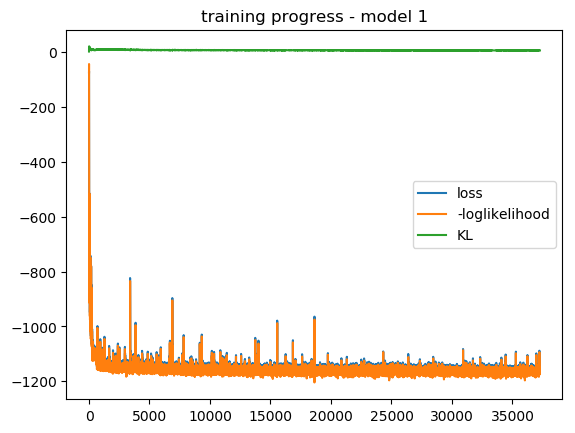

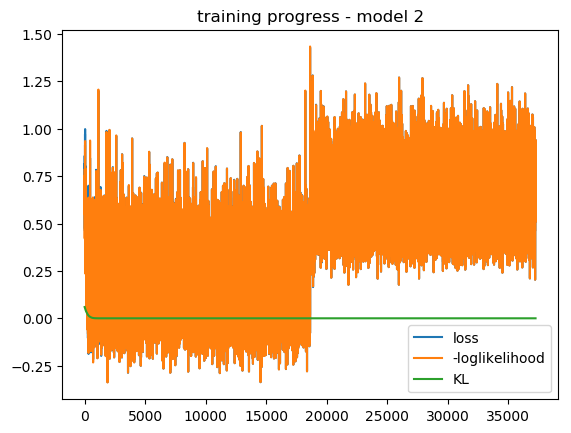

PyObject <matplotlib.legend.Legend object at 0x7f131f5930b8>

In [13]:
if modelname == "TSVAE"
    figure()
    title("training progress - model 1")
    h = history[1]
    plotvaeprogress(h)
    legend()
    
    figure()
    title("training progress - model 2")
    h = history[2]
    plotvaeprogress(h)
    legend()
end

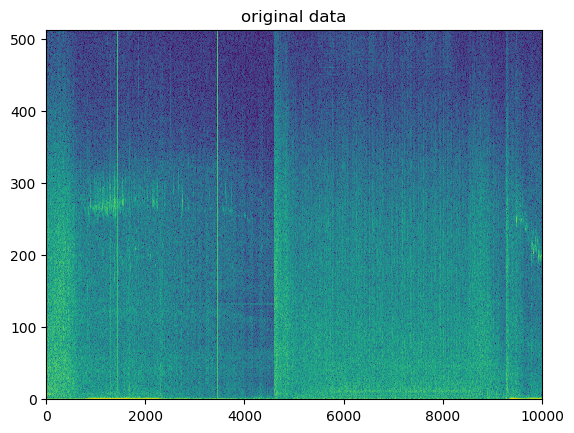

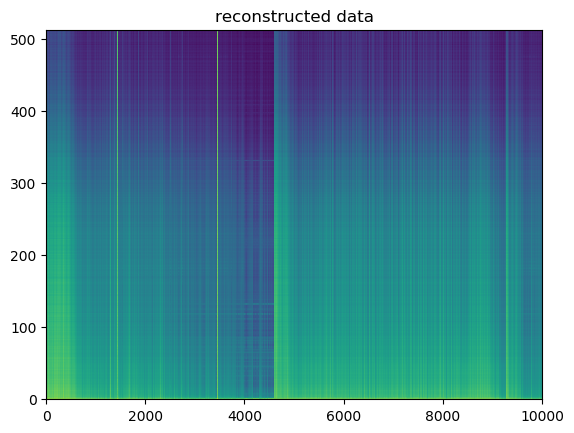

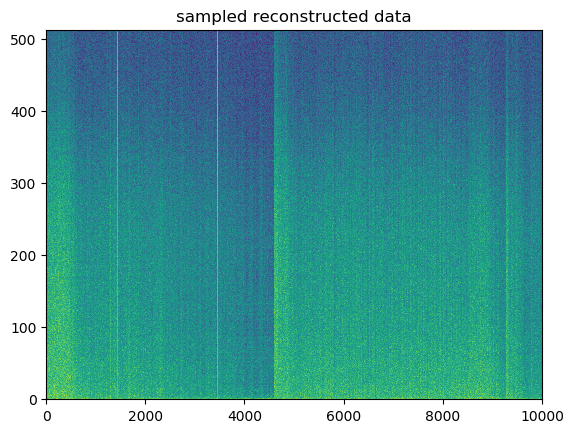

PyObject <matplotlib.collections.QuadMesh object at 0x7f131d43dc18>

In [14]:
X = data[:,1:10000]
rX = model(X).data[1:end-1,:]
srX = AlfvenDetectors.samplenormal_scalarvar(model(X).data)
pcolormesh(X)
title("original data")
figure()
title("reconstructed data")
pcolormesh(rX)
figure()
title("sampled reconstructed data")
pcolormesh(srX)

In [15]:
z = model.m1.encoder(data).data;
sz = model.m1.sampler(z);
z = z[1:ldim,:]
u = model.m2.encoder(z).data;
#u = model.m2.encoder(sz).data;
su = model.m2.sampler(u);
u = u[1:ldim,:]
GC.gc()

In [16]:
z_umap_model = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1)    
if ldim > 2
    #@time Matrix(umap_model.fit_transform((z[:,1:1000])')')
    @time z2D = Matrix(z_umap_model.fit_transform((z)')')
else
    z2D = z
end

2×17800 Array{Float32,2}:
 -1.28186   -1.32304   -1.31497   …  -0.0313151  0.481293  0.419493
 -0.739212  -0.688583  -0.891827      0.617755   1.44431   1.31652 

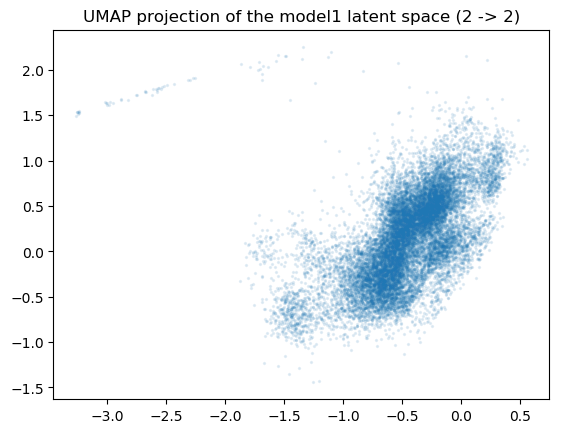

PyObject Text(0.5, 1.0, 'UMAP projection of the model1 latent space (2 -> 2)')

In [17]:
scatter(z2D[1,:], z2D[2,:], s= 2, alpha= 0.1)
title("UMAP projection of the model1 latent space ($ldim -> 2)")

### Also lets look at model 2

In [18]:
u_umap_model = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1)
if ldim > 2
    #@time Matrix(umap_model.fit_transform((z[:,1:1000])')')
    @time u2D = Matrix(u_umap_model.fit_transform((u)')')
else
    u2D = u
end

2×17800 Array{Float32,2}:
 -0.000123658  -0.000123658  -0.000123658  …  -0.000123658  -0.000123658
  0.000102006   0.000102006   0.000102006      0.000102006   0.000102006

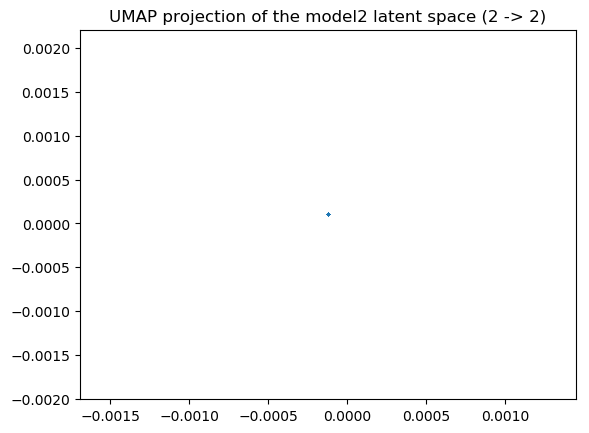

PyObject Text(0.5, 1.0, 'UMAP projection of the model2 latent space (2 -> 2)')

In [19]:
scatter(u2D[1,:], u2D[2,:], s= 2, alpha= 0.1)
title("UMAP projection of the model2 latent space ($ldim -> 2)")

### Try to select shots where there should be an Alfven mode and project them into the latent space.

In [24]:
function get_shot_data_code_and_projection(shot, coil, readfun, m1_umap_model, m2_umap_model)
    f = joinpath(datapath, "Jldata$(shot).h5")
    if measurement_type == "uprobe"
        data = AlfvenDetectors.get_ft_signal(f, readfun)
    else
        data = AlfvenDetectors.get_ft_signals(f, readfun, coil)
    end
    z = (model.m1.encoder(data).data)[1:ldim,:]
    if ldim > 2
        z2D = Matrix(m1_umap_model.transform(z')')
    else
        z2D = z
    end
    u = (model.m2.encoder(z).data)[1:ldim,:]
    if ldim > 2
        u2D = Matrix(m2_umap_model.transform(u')')
    else
        u2D = u
    end
    return data, z, z2D, u, u2D
end

get_shot_data_code_and_projection (generic function with 1 method)

In [25]:
shotlist = [(10000,12), (10893,14), (10370,12)]
alldata = map(x->get_shot_data_code_and_projection(x[1], x[2], readfun, z_umap_model, u_umap_model),shotlist);

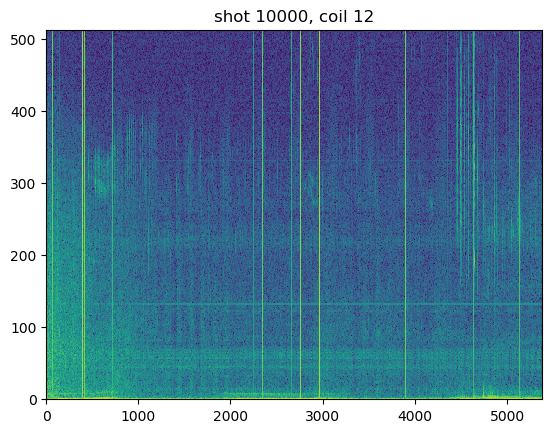

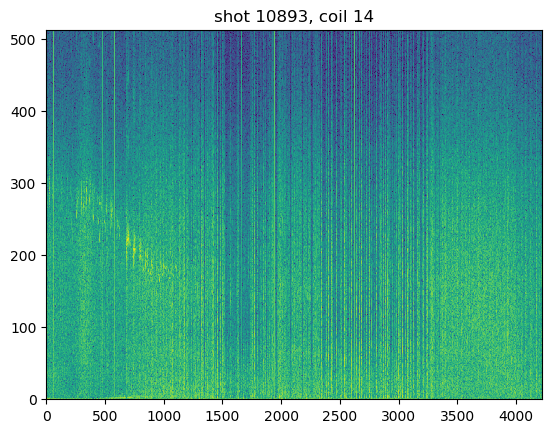

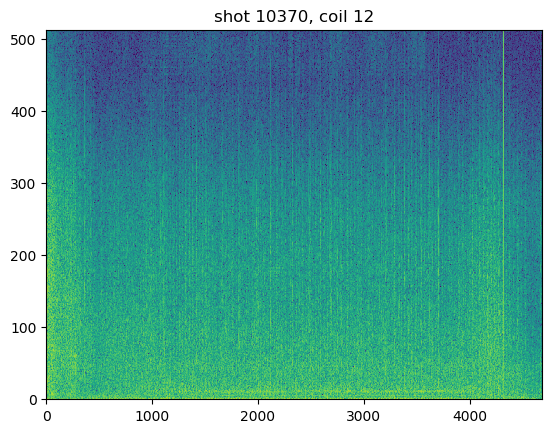

In [26]:
for (shotinfo,shotdata) in zip(shotlist,alldata)
    figure()
    title("shot $(shotinfo[1]), coil $(shotinfo[2])")
    pcolormesh(shotdata[1])
end

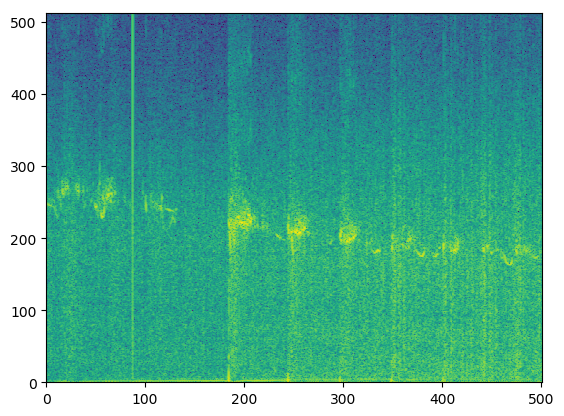

2×501 Array{Float32,2}:
 -1.10833   -1.0652    -1.21218   …  -1.6635    -1.51048    -1.401   
  0.374566   0.105596   0.309098     -0.070153   0.0514775   0.119133

In [30]:
inds = 500:1000
chirpx = alldata[2][1][:,inds]
pcolormesh(chirpx)
chirpz = (model.m1.encoder(chirpx).data)[1:ldim,:]

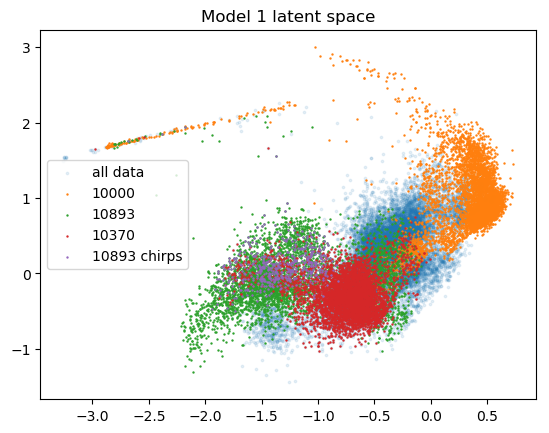

PyObject Text(0.5, 1.0, 'Model 1 latent space')

In [31]:
scatter(z2D[1,:], z2D[2,:], s=3, alpha= 0.1, label="all data")
for (shotinfo,shotdata) in zip(shotlist, alldata)
    scatter(shotdata[3][1,:],shotdata[3][2,:], label=shotinfo[1], s=0.5,alpha=1)
end
scatter(chirpz[1,:], chirpz[2,:], label = "10893 chirps", s=0.5,alpha=1)
legend()
title("Model 1 latent space")

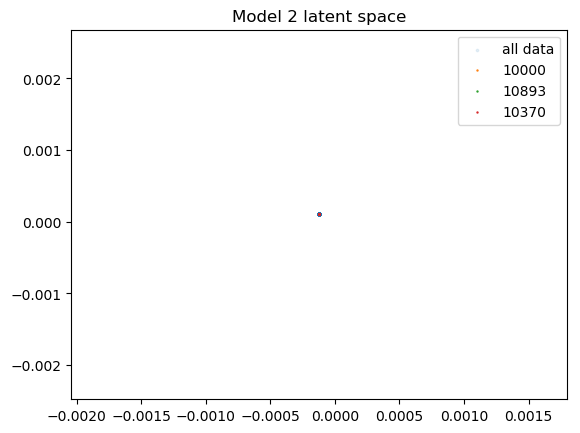

PyObject Text(0.5, 1.0, 'Model 2 latent space')

In [28]:
scatter(u2D[1,:], u2D[2,:], s=3, alpha= 0.1, label="all data")
for (shotinfo,shotdata) in zip(shotlist, alldata)
    scatter(shotdata[5][1,:],shotdata[5][2,:], label=shotinfo[1], s=0.5,alpha=1)
end
legend()
title("Model 2 latent space")